In [14]:
del visualize_dataset
del visualize_detections

In [15]:
import keras_cv
import tensorflow as tf
from adlc_util import visualize_dataset, visualize_detections
import tqdm

class_mapping = {0:"target"}

In [2]:
# NOTE: this requires tensorflow>=2.14 on linux: https://github.com/XiaotingChen/maxatac_pip_1.0.5/issues/2
train_ds = tf.data.Dataset.load(path="data/238_train_ds", compression="GZIP")
test_ds = tf.data.Dataset.load(path="data/238_test_ds", compression="GZIP")

augmenter = tf.keras.Sequential(
    layers=[
        keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xywh"),
        keras_cv.layers.JitteredResize(
            target_size=(640, 640),
            scale_factor=(0.75, 1.3),
            bounding_box_format="xywh",
        ),
    ]
)

train_ds = train_ds.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)

inference_resizing = keras_cv.layers.Resizing(
    640, 640, bounding_box_format="xywh", pad_to_aspect_ratio=True
)
test_ds = test_ds.map(inference_resizing, num_parallel_calls=tf.data.AUTOTUNE)

# visualize_dataset(
#     train_ds, bounding_box_format="xywh", value_range=(0, 255), rows=2, cols=2, offset=1
# )

2023-11-07 19:21:18.396699: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-07 19:21:18.510307: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_pr

In [3]:
def dict_to_tuple(inputs):
    return inputs["images"], keras_cv.bounding_box.to_dense(
        inputs["bounding_boxes"], max_boxes=32
    )



train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)

train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

Optimizer

In [4]:
base_lr = 0.005
# including a global_clipnorm is extremely important in object detection tasks
optimizer = tf.keras.optimizers.SGD(
    learning_rate=base_lr, momentum=0.9, global_clipnorm=10.0
)

Loss

In [5]:
def get_backbone():
    """Builds ResNet50 with pre-trained imagenet weights"""
    backbone = tf.keras.applications.ResNet50(
        include_top=False, input_shape=[None, None, 3]
    )
    c3_output, c4_output, c5_output = [
        backbone.get_layer(layer_name).output
        for layer_name in ["conv3_block4_out", "conv4_block6_out", "conv5_block3_out"]
    ]
    return tf.keras.Model(
        inputs=[backbone.inputs], outputs=[c3_output, c4_output, c5_output]
    )

# resnet50_backbone = get_backbone()
# model = keras_cv.models.RetinaNet(num_classes=1, backbone=resnet50_backbone, bounding_box_format="xywh")

model = keras_cv.models.RetinaNet(
    num_classes=len(class_mapping),
    bounding_box_format="xywh",
    backbone=keras_cv.models.ResNet50Backbone.from_preset(
        "resnet50_imagenet"
    )
)


prediction_decoder = keras_cv.layers.MultiClassNonMaxSuppression(
    bounding_box_format="xywh",
    from_logits=True,
    # Decrease the required threshold to make predictions get pruned out
    iou_threshold=0.2,
    # Tune confidence threshold for predictions to pass NMS
    confidence_threshold=0.7,
)
model.prediction_decoder = prediction_decoder

In [6]:
model.compile(
    classification_loss="focal",
    box_loss="smoothl1",
)

Metric

In [7]:
coco_metrics = keras_cv.metrics.BoxCOCOMetrics(
    bounding_box_format="xywh", evaluate_freq=20
)

def print_metrics(metrics):
    maxlen = max([len(key) for key in result.keys()])
    print("Metrics:")
    print("-" * (maxlen + 1))
    for k, v in metrics.items():
        print(f"{k.ljust(maxlen+1)}: {v.numpy():0.2f}")


In [8]:
model.compile(
    classification_loss="focal",
    box_loss="smoothl1",
    optimizer=optimizer,
    metrics=[coco_metrics],
)
coco_metrics.reset_state()
result = model.evaluate(test_ds.take(1), verbose=0)
result = coco_metrics.result(force=True)

print_metrics(result)

[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 9248101659133665665


Metrics:
----------------------------
MaP                         : 0.00
MaP@[IoU=50]                : 0.00
MaP@[IoU=75]                : 0.00
MaP@[area=small]            : 0.00
MaP@[area=medium]           : 0.00
MaP@[area=large]            : 0.00
Recall@[max_detections=1]   : 0.00
Recall@[max_detections=10]  : 0.00
Recall@[max_detections=100] : 0.00
Recall@[area=small]         : 0.00
Recall@[area=medium]        : 0.00
Recall@[area=large]         : 0.00


Create Model

In [9]:
model = keras_cv.models.RetinaNet.from_preset(
    "resnet50_imagenet",
    num_classes=len(class_mapping),
    # For more info on supported bounding box formats, visit
    # https://keras.io/api/keras_cv/bounding_box/
    bounding_box_format="xywh",
)

Training

In [10]:
model.compile(
    classification_loss="focal",
    box_loss="smoothl1",
    optimizer=optimizer,
    # We will use our custom callback to evaluate COCO metrics
    metrics=None,
)

In [47]:
class EvaluateCOCOMetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, data):
        super().__init__()
        self.data = data
        self.metrics = keras_cv.metrics.BoxCOCOMetrics(
            bounding_box_format="xywh",
            # passing 1e9 ensures we never evaluate until
            # `metrics.result(force=True)` is
            # called.
            evaluate_freq=1e9,
        )

    def on_epoch_end(self, epoch, logs):
        self.metrics.reset_state()
        for batch in tqdm.tqdm(self.data):
            images, y_true = batch[0], batch[1]
            y_pred = self.model.predict(images, verbose=0)
            self.metrics.update_state(y_true, y_pred)

        metrics = self.metrics.result(force=True)
        logs.update(metrics)
        return logs


model.fit(
    train_ds.take(20),
    validation_data=test_ds.take(20),
    # Run for 10-35~ epochs to achieve good scores.
    epochs=1,
    callbacks=[EvaluateCOCOMetricsCallback(test_ds.take(20)), 
    # VisualizeDetections(test_ds.take(20)) # not sure how to pass the visualizations
    ],
)

[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 6185965837752199360


6/6 [==============================] - ETA: 0s - loss: 0.0000e+00 - box_loss: 0.0000e+00 - classification_loss: 0.0000e+00 - percent_boxes_matched_with_anchor: 0.9688

  0%|          | 0/1 [00:00<?, ?it/s][libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 9248101659133665665
100%|██████████| 1/1 [00:02<00:00,  2.01s/it]

6/6 [==============================] - 21s 3s/step - loss: 0.0000e+00 - box_loss: 0.0000e+00 - classification_loss: 0.0000e+00 - percent_boxes_matched_with_anchor: 0.9688 - val_loss: 0.0000e+00 - val_box_loss: 0.0000e+00 - val_classification_loss: 0.0000e+00 - val_percent_boxes_matched_with_anchor: 0.9688 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00


In [34]:
visualization_ds = test_ds.unbatch()
visualization_ds = visualization_ds.ragged_batch(16)
visualization_ds = visualization_ds.shuffle(8)

In [35]:
from keras_cv import visualization
from keras_cv import bounding_box
CLASS_MAPPING = {0:"target"}

def visualize_detections(model, dataset, bounding_box_format, offset=1):
    it = iter(dataset.take(offset))

    for _ in range(offset):
        images, y_true = next(it)

    # images, y_true = next(iter(dataset.take(1)))
    y_pred = model.predict(images)
    y_pred = bounding_box.to_ragged(y_pred)
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        scale=20,
        rows=2,
        cols=2,
        show=True,
        font_scale=0.7,
        class_mapping=CLASS_MAPPING,
    )

[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 9248101659133665665


1/1 [==============================] - 2s 2s/step


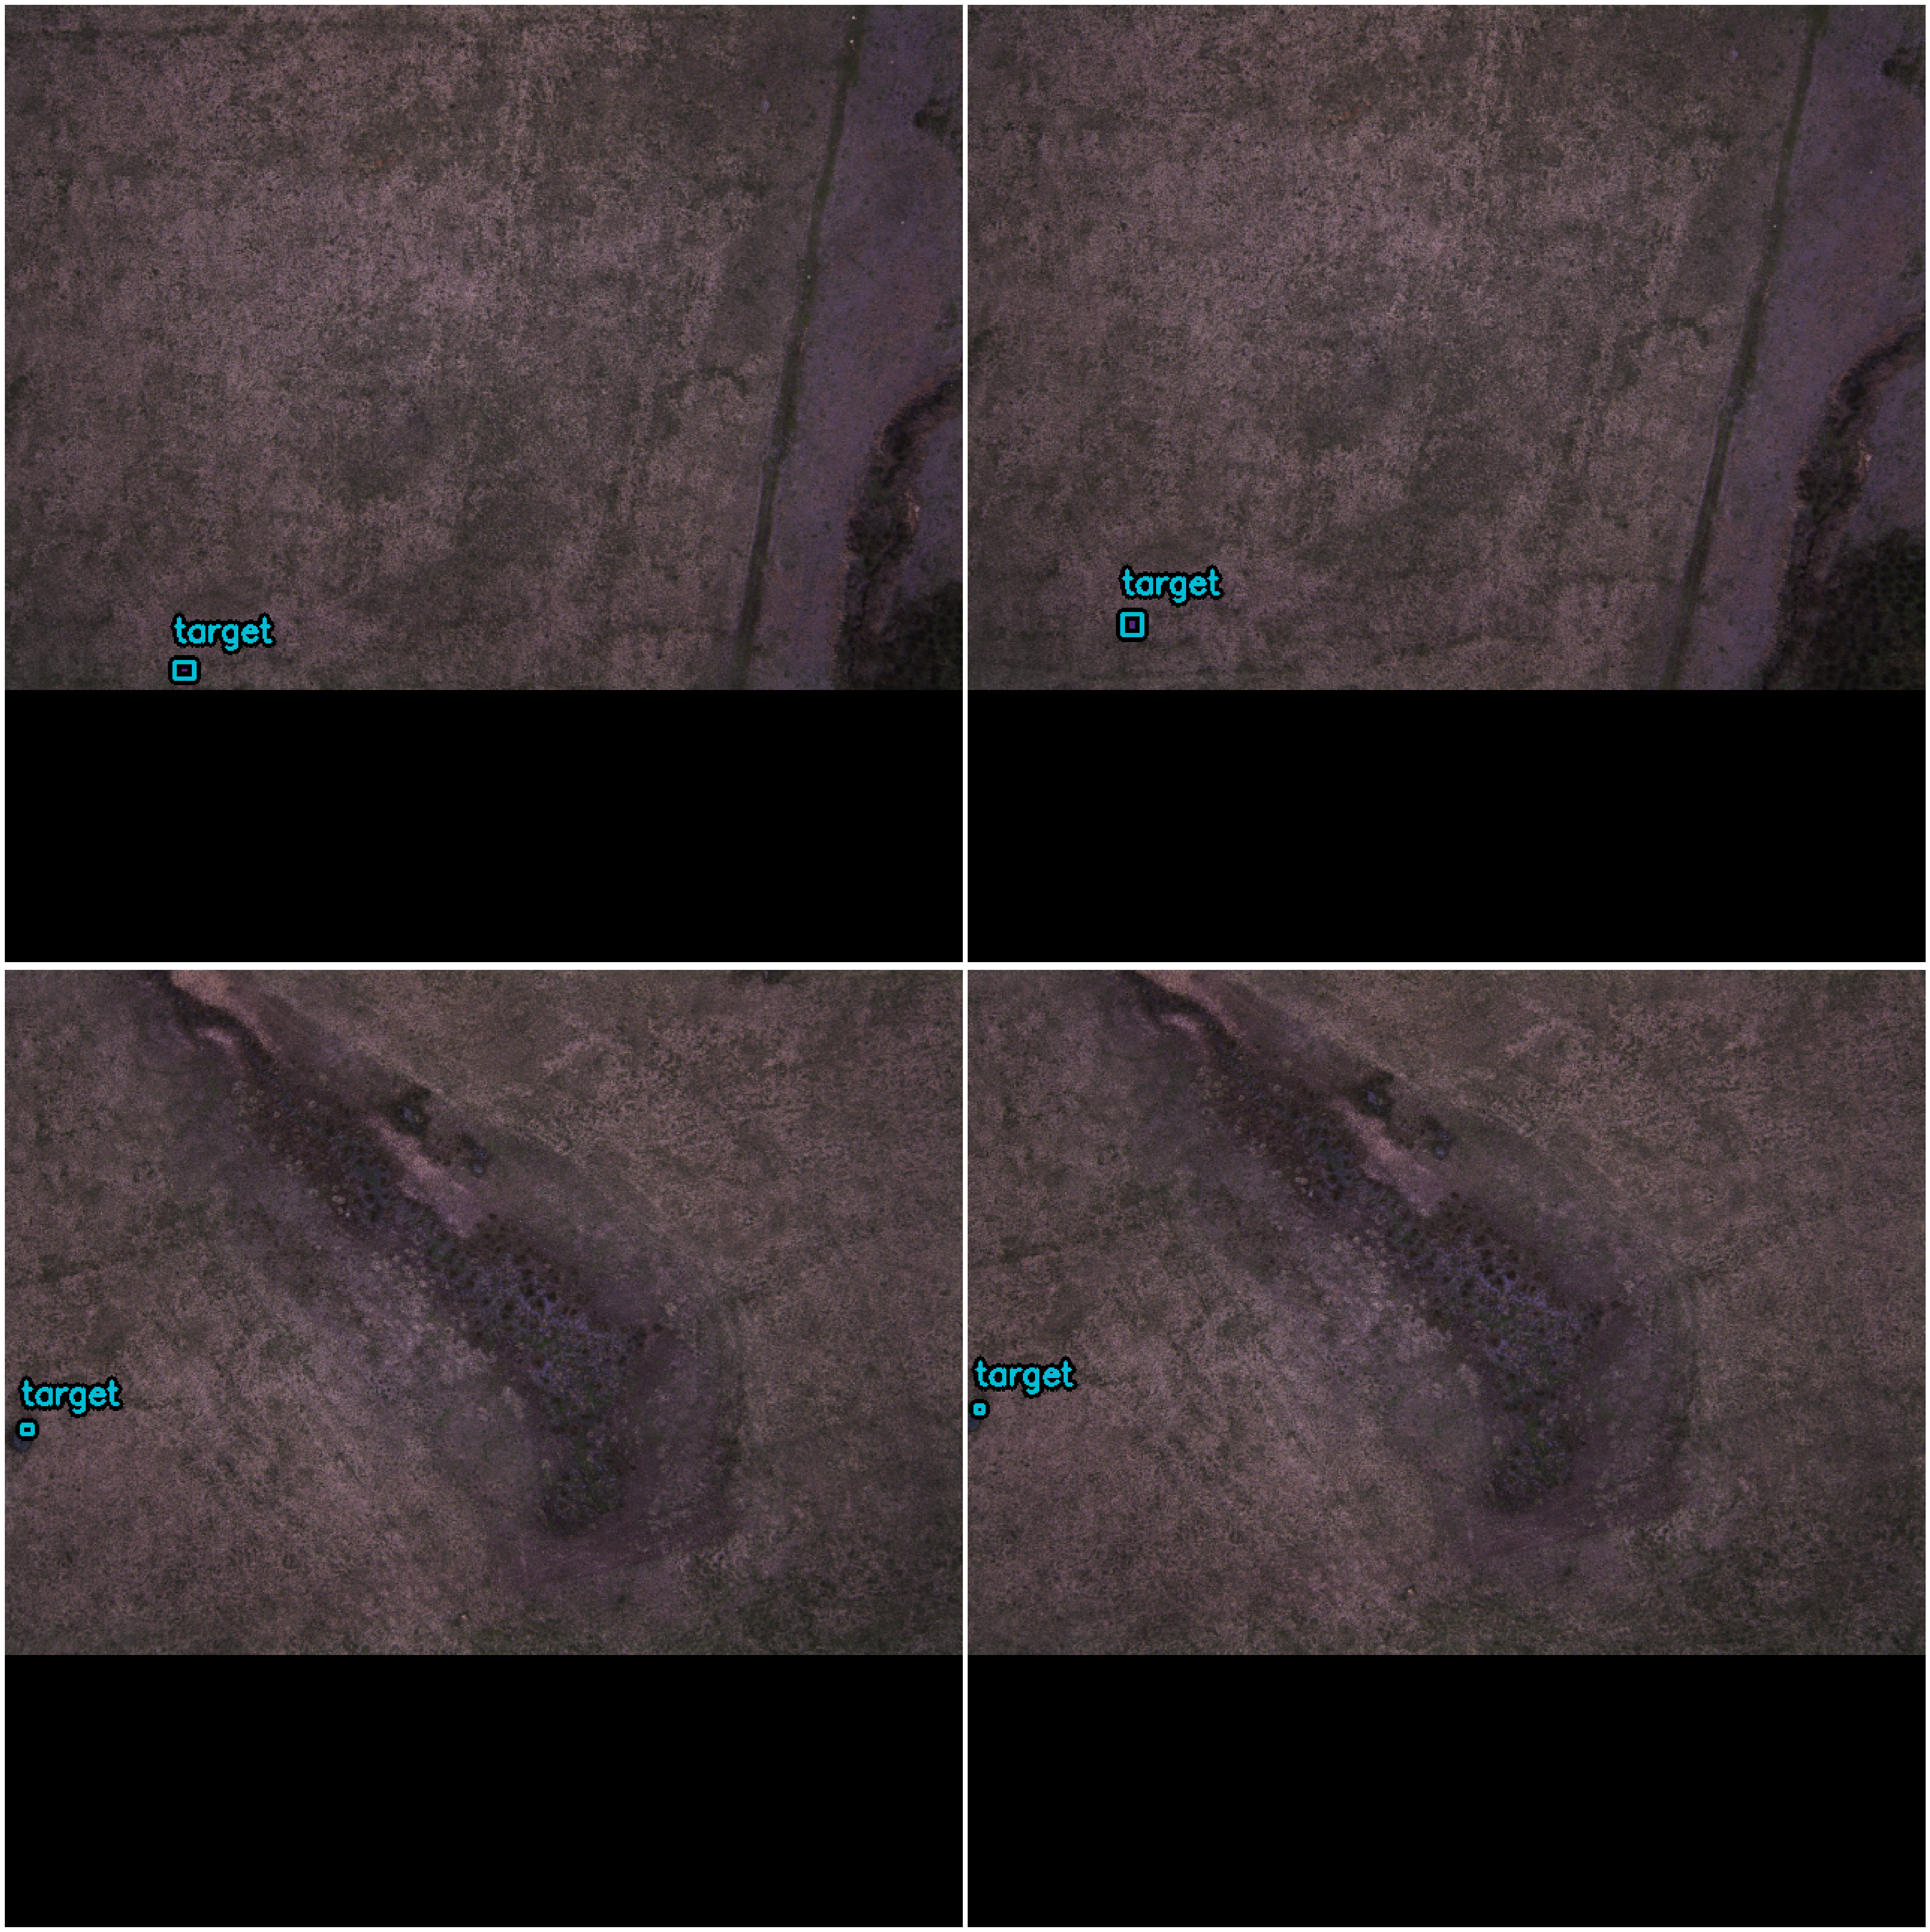

In [36]:
model.prediction_decoder = keras_cv.layers.MultiClassNonMaxSuppression(
    bounding_box_format="xywh",
    from_logits=True,
    iou_threshold=0.5,
    confidence_threshold=0.75,
)

visualize_detections(model, dataset=visualization_ds, bounding_box_format="xywh")

In [45]:
class VisualizeDetections(tf.keras.callbacks.Callback):
    def __init__(self, data):
        super().__init__()
        self.data = data.unbatch()

    def on_epoch_end(self, epoch, logs):
        visualize_detections(
            self.model, bounding_box_format="xywh", dataset=self.data
        )